# <font color='#1a5276'> <b> <center> Neural Networks </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data](#4)
5. [Model and cost function](#5)
6. [Batch Gradient Descent](#6)
7. [Stochastic Gradient Descent](#7)
8. [Mini-batch Gradient Descent](#8)
9. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In this notebook, we'll walk through several examples of shallow neural networks using PyTorch. The goal is to learn how to define, train, and evaluate a neural network.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [50]:
import torch 
import torch.nn as nn
from torch import sigmoid
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [3]:
torch.manual_seed(0)

<a name="3"></a>
## <font color='blue'> <b> 3. Example 1 </b> </font>

We will start by implementing the following arquitecture:
    
        Input -> Linear1 -> Sigmoid -> Linear2 -> Sigmoid -> Output
    

<a name="3.1"></a>
### <font color='#1a5276'> <b> 3.1. Helper Functions </b> </font>

In [10]:
# Plots the predictions of a model alongside the actual values, and it labels the plot with the current epoch.
def plot_stuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    plt.xlabel('x')
    if leg == True:
        plt.legend()
    else:
        pass
    
    
# Plot data
def plot_data(X, Y):
    # Convert tensors to NumPy arrays for plotting
    X_np = X.numpy()
    Y_np = Y.numpy()
    
    # Create a scatter plot with X on the x-axis and Y on the y-axis
    plt.scatter(X_np, Y_np, color='blue', label='Data points')
    
    # Label the axes
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Add a title
    plt.title('Plot of X vs Y')
    
    # Optionally, add a grid for better visualization
    plt.grid(True)
    
    # Show the plot
    plt.show()

<a name="3.2"></a>
### <font color='#1a5276'> <b> 3.2. Data </b> </font>

We will create synthetic data.

In [9]:
# Generate a tensor X with values ranging from -20 to 20 (step size of 1)
X = torch.arange(-20, 20, 1).view(-1, 1).type(torch.FloatTensor)

# Initialize a tensor Y with the same number of rows as X, filled with zeros
Y = torch.zeros(X.shape[0])

# Set Y to 1.0 for values of X between -4 and 4 (exclusive)
Y[(X[:, 0] > -4) & (X[:, 0] < 4)] = 1.0

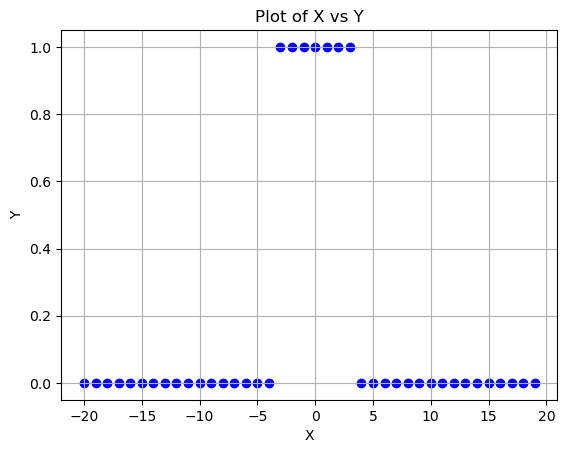

In [11]:
plot_data(X, Y)

<a name="3.3"></a>
### <font color='#1a5276'> <b> 3.3. Model architecture, training and evaluation </b> </font>

In [33]:
# size of input 
D_in = 1

# size of hidden layer 
H = 2

# number of outputs 
D_out = 1

# learning rate 
learning_rate = 0.1

The model will have the following architecture:

<img src="images/SimpleNet.png"/>

<br>
<center> <b> Model architecture </b> </center>

In [34]:
class Net1(nn.Module):
    """
    A simple feedforward neural network with two layers and sigmoid activations.

    This model consists of two fully connected layers (`linear1` and `linear2`),
    with a sigmoid activation applied after the first layer. The model also
    stores intermediate activations (`a1`, `l1`) and outputs predictions (`yhat`).
    These intermediate results are tracked for the purpose of visualizing the activations.
    Although storing activations as attributes is not considered a good practice, it is done here
    for educational purposes and to enable plotting intermediate activations during training.

    Attributes:
    -----------
    a1 : Tensor
        The activations after the first layer (used for visualization).
    l1 : Tensor
        The linear output after the first layer (used for visualization).
    l2 : Tensor
        The output of the second linear layer.
    """

    # Constructor
    def __init__(self, D_in, H, D_out):
        """
        Initialize the network layers.

        Parameters:
        -----------
        D_in : int
            The number of input features.
        H : int
            The number of hidden units in the hidden layer.
        D_out : int
            The number of output units (the dimensionality of the output).
        """
        super(Net1, self).__init__()
        
        # Define the hidden layer (linear1) and the output layer (linear2)
        self.linear1 = nn.Linear(D_in, H)  # First linear layer (input to hidden)
        self.linear2 = nn.Linear(H, D_out)  # Second linear layer (hidden to output)
        
        # Initialize variables to store activations and outputs, used for plotting intermediate results
        self.a1 = None  # Activation after the first layer (hidden layer)
        self.l1 = None  # Output from the first linear layer (before activation)
        self.l2 = None  # Output from the second linear layer (before final activation)
    
    # Prediction (Forward pass)
    def forward(self, x):
        """
        Perform the forward pass through the network.

        This function computes the output `yhat` of the network by passing the input `x` 
        through the first linear layer, applying the sigmoid activation, passing it through 
        the second linear layer, and applying a final sigmoid activation.

        Parameters:
        -----------
        x : Tensor
            The input tensor to the network.

        Returns:
        --------
        yhat : Tensor
            The predicted output of the network (after the final sigmoid activation).
        """
        # First layer: compute linear transformation (l1) and apply activation (a1)
        self.l1 = self.linear1(x)  # Linear transformation from input to hidden
        self.a1 = torch.sigmoid(self.l1)  # Apply sigmoid activation after the first layer
        
        # Second layer: compute output (l2) and final prediction (yhat)
        self.l2 = self.linear2(self.a1)  # Linear transformation from hidden to output
        yhat = torch.sigmoid(self.l2)  # Apply sigmoid activation at the output layer

        # Return the final prediction
        return yhat


In [70]:
# Training function
def train(X, Y, model, optimizer, criterion, epochs=1000):
    """
    Train a neural network model using the given data, optimizer, and loss function.

    This function performs the training loop for the specified number of epochs.
    It computes the forward pass, calculates the loss, performs backpropagation,
    and updates the model parameters using the optimizer. The cumulative loss is
    tracked and plotted every 300 epochs. 

    Parameters:
    -----------
    Y : tensor
        The target output values.
    X : tensor
        The input features.
    model : nn.Module
        The neural network model to be trained.
    optimizer : torch.optim.Optimizer
        The optimizer used to update model parameters.
    criterion : nn.Module
        The loss function used to calculate the error.
    epochs : int, optional
        The number of epochs to train the model (default is 1000).

    Returns:
    --------
    cost : list
        A list containing the cumulative loss at the end of each epoch.
    model : nn.Module
        The trained neural network model after the training loop.
    """
    
    cost = []  # List to track the cost (loss) at each epoch
    total = 0   # Initialize total loss for the epoch
    
    for epoch in range(epochs):
        total = 0  # Reset total loss for the current epoch
        
        for x, y in zip(X, Y):  # Iterate through the data (Y, X) pairs
            yhat = model(x)  # Forward pass: compute model output
            loss = criterion(yhat, y)  # Calculate loss between predictions and target
            
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update model parameters
            optimizer.zero_grad()  # Reset gradients to zero for next iteration
            
            # Add the current loss value to the total loss for the epoch
            total += loss.item()  
        
        cost.append(total)  # Append the total loss of the epoch to the cost list
        
        # Plotting the model's predictions and activations every 300 epochs
        if epoch % 300 == 0:    
            plot_stuff(X, Y, model, epoch, leg=True)  # Plot the model predictions
            plt.show()  # Show the plot
            model(X)  # Compute the forward pass to access activations
            
            # Plot the activations of the first hidden layer (a1)
            plt.scatter(model.a1.detach().numpy()[:, 0], 
                        model.a1.detach().numpy()[:, 1], 
                        c=Y.numpy().reshape(-1))
            plt.title('Activations')  # Set the plot title
            plt.show()  # Display the activation plot
    
    return cost, model  # Return the list of cumulative losses and the trained model


In [35]:
# create an instance of the model
model1 = Net1(D_in, H, D_out)

In [36]:
# criterion
def criterion(yhat, y):
    return -torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))

In [37]:
#optimizer 
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

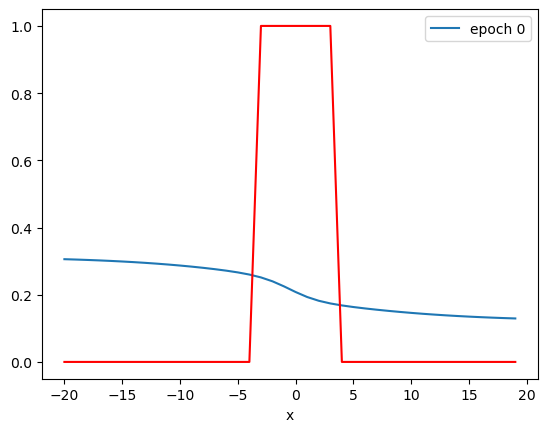

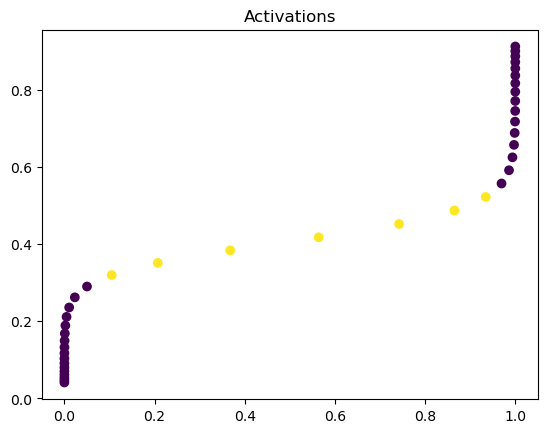

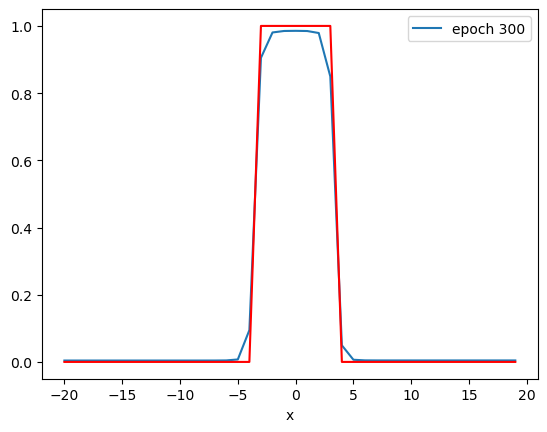

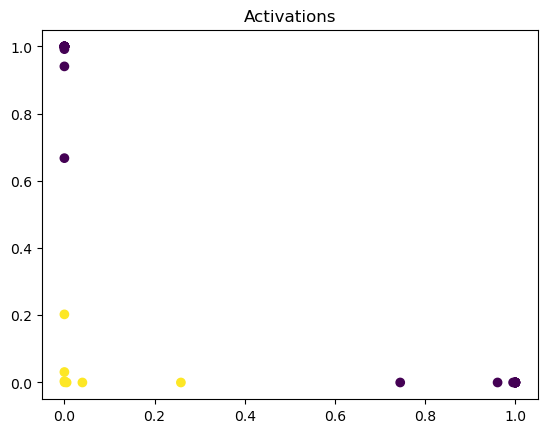

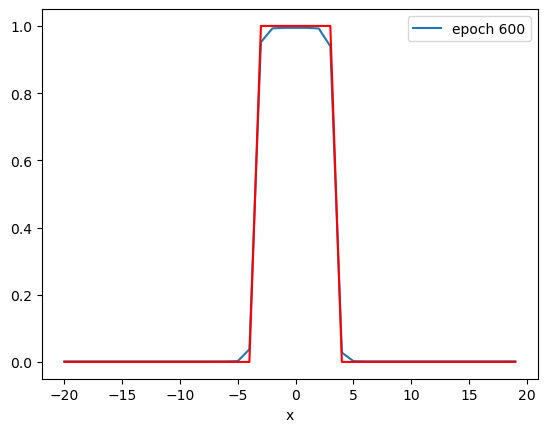

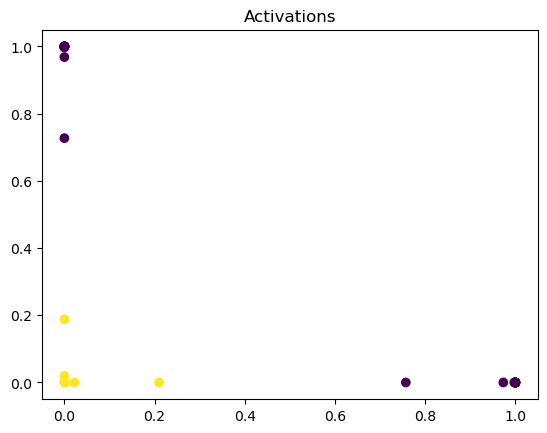

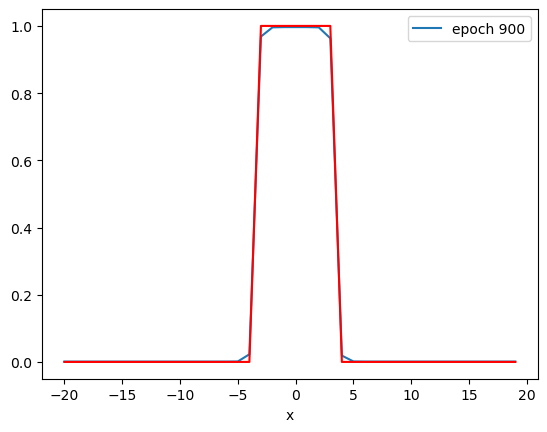

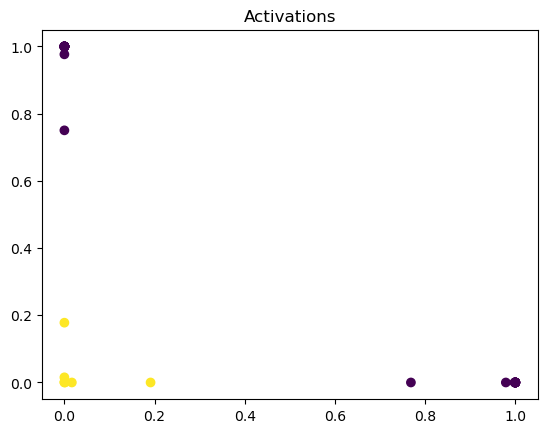

In [40]:
# train the model
cost, trained_model_1 = train(X, Y, model1, optimizer, criterion, epochs=1000)

Examining the activation output, we see that by epoch 600, the data has been mapped to a linearly separable space.

Text(0.5, 1.0, 'Cross-entropy loss')

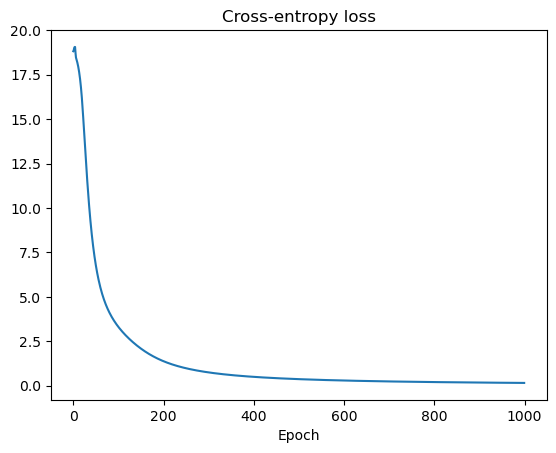

In [41]:
#plot the loss
plt.plot(cost)
plt.xlabel('Epoch')
plt.title('Cross-entropy loss')

### Predictions

In [43]:
# one prediction
x = torch.tensor([0.0])
yhat = trained_model_1(x)
yhat

tensor([0.9969], grad_fn=<SigmoidBackward0>)

In [45]:
# several predictions
X_= torch.tensor([[0.0],[2.0],[3.0]])
Yhat = trained_model_1(X_)
Yhat

tensor([[0.9969],
        [0.9962],
        [0.9675]], grad_fn=<SigmoidBackward0>)

In [46]:
# we can apply a threshold
Yhat = Yhat > 0.5
Yhat

tensor([[True],
        [True],
        [True]])

<a name="4"></a>
## <font color='blue'> <b> 4. Example 2 </b> </font>

Now the data will be a little more complex.

<a name="4.1"></a>
### <font color='#1a5276'> <b> 4.1. Helper Functions </b> </font>


In [57]:
# histogram
def get_hist(model, dataset):
    activations = model.activation(dataset.x)
    for i,activation in enumerate(activations):
        plt.hist(activation.numpy(), 4, density=True)
        plt.title("Activation layer " + str(i+1))
        plt.xlabel("Activation")
        plt.xlabel("Activation")
        plt.legend()
        plt.show()
        
        
# plot training points and predictions
def plot_stuff(X,Y,model=None,leg=False):
    
    plt.plot(X[Y==0].numpy(),Y[Y==0].numpy(),'or',label='training points y=0 ' )
    plt.plot(X[Y==1].numpy(),Y[Y==1].numpy(),'ob',label='training points y=1 ' )

    if model!=None:
        plt.plot(X.numpy(),model(X).detach().numpy(),label='neral network ')

    plt.legend()
    plt.show()


<a name="4.2"></a>
### <font color='#1a5276'> <b> 4.2. Data </b> </font>

In [51]:
class Data(Dataset):
    """
    Custom dataset class for generating synthetic data.

    This dataset generates input data `x` in the range [-20, 20] and creates corresponding labels `y`
    based on specific ranges of `x`. The class implements the PyTorch `Dataset` interface, allowing it 
    to be used with a DataLoader for batch processing.

    - Input `x` is a 100-point tensor of linearly spaced values between -20 and 20.
    - Output `y` is a binary label tensor, where:
        - Label `1` is assigned to values of `x` in the ranges (-10, -5) and (5, 10).
        - Label `0` is assigned to all other values of `x`.

    Attributes:
    ----------
    x : Tensor
        Input data, a 100-point tensor linearly spaced between -20 and 20.
    y : Tensor
        Labels corresponding to the input data. The values are 1 for certain ranges of `x` and 0 otherwise.
    len : int
        The length of the dataset (number of samples).
    """

    def __init__(self):
        """
        Initialize the dataset by generating the input data `x` and the corresponding labels `y`.

        The input data `x` is generated using `torch.linspace` to create 100 linearly spaced values from -20 to 20.
        Labels `y` are assigned based on specific conditions applied to `x`. The labels are 1 for certain
        ranges of `x` and 0 otherwise.

        The length of the dataset is computed as the number of input samples.
        """
        # Generate 100 points linearly spaced between -20 and 20
        self.x = torch.linspace(-20, 20, 100).view(-1, 1)

        # Initialize labels to zeros
        self.y = torch.zeros(self.x.shape[0])

        # Assign label 1 for x values in the range (-10, -5) and (5, 10)
        self.y[(self.x[:, 0] > -10) & (self.x[:, 0] < -5)] = 1
        self.y[(self.x[:, 0] > 5) & (self.x[:, 0] < 10)] = 1

        # Reshape the labels to be column vectors
        self.y = self.y.view(-1, 1)

        # Store the length of the dataset
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        """
        Retrieve the input-output pair at the specified index.

        Parameters:
        -----------
        index : int
            The index of the data sample to retrieve.

        Returns:
        --------
        tuple : (Tensor, Tensor)
            A tuple containing the input data `x` and the corresponding label `y`.
        """
        return self.x[index], self.y[index]

    def __len__(self):
        """
        Return the length of the dataset (number of samples).

        Returns:
        --------
        int
            The number of samples in the dataset.
        """
        return self.len


In [54]:
# create a Data object
dataset = Data()

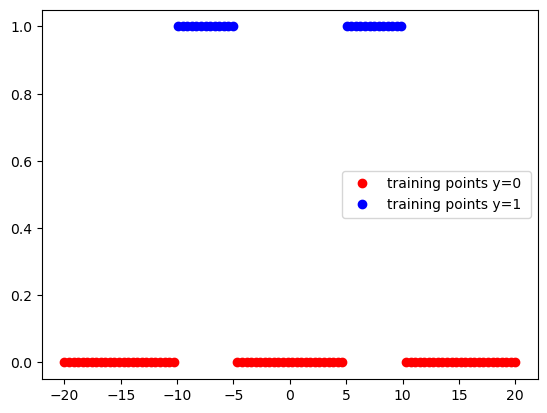

In [56]:
# plot data
plot_stuff(dataset.x, dataset.y, leg=False)

<a name="4.3"></a>
### <font color='#1a5276'> <b> 4.3. Model architecture, training and evaluation </b> </font>

In [58]:
# size of input 
D_in = 1

# size of hidden layer 
H = 9

# number of outputs 
D_out = 1

# learning rate 
learning_rate = 0.1

The model will have the following architecture:

<img src="images/SimpleNet.png"/>

<br>
<center> <b> Model architecture </b> </center>

In [63]:
# Model architecture
class Net2(nn.Module):
    """
    A simple neural network with one hidden layer.

    Attributes:
    -----------
    linear1 : nn.Linear
        The first linear layer that maps input features to the hidden layer.
    linear2 : nn.Linear
        The second linear layer that maps the hidden layer to the output.

    Methods:
    --------
    forward(x):
        Defines the forward pass of the neural network.
    """

    def __init__(self, D_in, H, D_out):
        """
        Initialize the neural network.

        Parameters:
        -----------
        D_in : int
            The number of input features.
        H : int
            The number of neurons in the hidden layer.
        D_out : int
            The number of output features.
        """
        super(Net2, self).__init__()
        # Define the first linear layer (input to hidden)
        self.linear1 = nn.Linear(D_in, H)
        # Define the second linear layer (hidden to output)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Perform the forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            The input tensor.

        Returns:
        --------
        torch.Tensor
            The output tensor after passing through the network.
        """
        # Pass input through the first layer and apply sigmoid activation
        x = torch.sigmoid(self.linear1(x))
        # Pass the result through the second layer and apply sigmoid activation
        x = torch.sigmoid(self.linear2(x))
        return x


In [67]:
# Training function
def train(dataset, model, criterion, train_loader, optimizer, epochs=5, plot_number=10):
    """
    Train a neural network model.

    Parameters:
    -----------
    dataset : Dataset
        The dataset object containing the input data and labels.
    model : nn.Module
        The neural network model to be trained.
    criterion : loss function
        The loss function used to compute the error between predictions and true labels.
    train_loader : DataLoader
        DataLoader object to load the training data in batches.
    optimizer : torch.optim.Optimizer
        The optimizer used to update the model's parameters.
    epochs : int, optional (default=5)
        The number of epochs (full passes through the dataset) to train the model.
    plot_number : int, optional (default=10)
        The frequency of plotting the model's performance during training.

    Returns:
    --------
    tuple:
        - cost : list
            The total loss for each epoch.
        - model : nn.Module
            The trained model.
    """

    cost = []  # List to store the total loss for each epoch
    
    for epoch in range(epochs):
        total = 0  # Accumulator for the total loss during the epoch
        
        for x, y in train_loader:
            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()
            
            # Forward pass: compute predictions
            yhat = model(x)
            
            # Compute the loss
            loss = criterion(yhat, y)
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Update model parameters
            optimizer.step()
            
            # Accumulate the loss
            total += loss.item()
            
            # Optionally plot intermediate results every 'plot_number' epochs
            if epoch % plot_number == 0:
                plot_stuff(dataset.x, dataset.y, model)
        
        # Append the total loss for the current epoch to the cost list
        cost.append(total)
    
    # Plot the cost over epochs
    plt.figure()
    plt.plot(cost)
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Training Cost vs. Epochs')
    plt.show()
    
    # Return the cost history and the trained model
    return cost, model


In [68]:
# instance of Net2
model_2 = Net2(D_in, H, D_out)

# criterion
criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr = learning_rate)

# train loader
train_loader = DataLoader(dataset = dataset, batch_size=100)

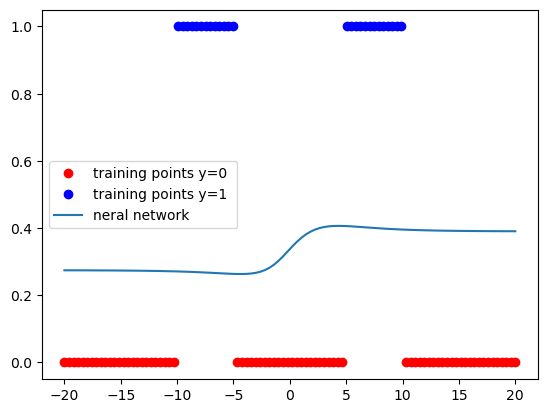

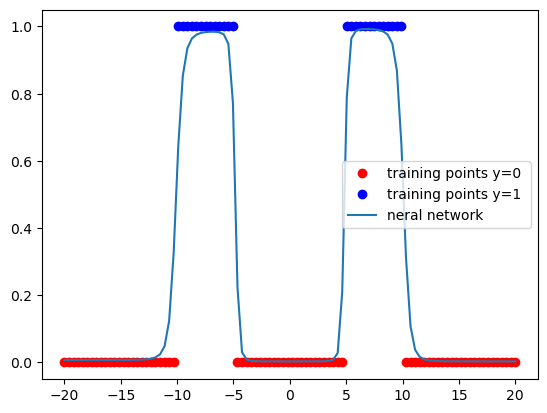

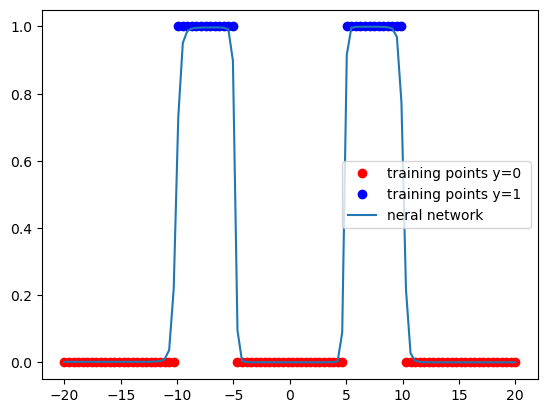

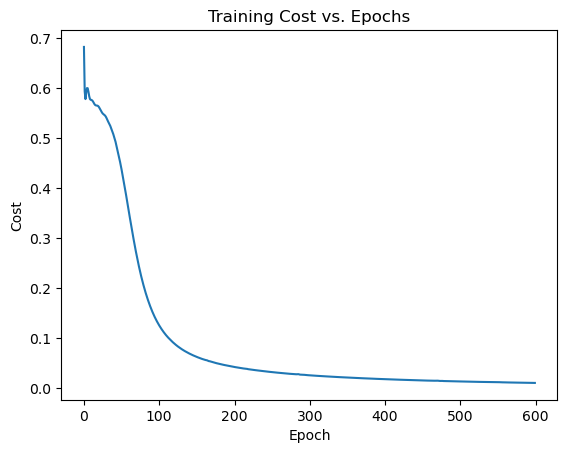

In [69]:
# train
cost, trained_model_2 = train(dataset, model_2 , criterion, train_loader, optimizer, epochs=600,plot_number=200)